In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    openmic_class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
with open("class_align.json", "r") as f: 
    class_align = json.load(f)

with open("genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

# cosine similarity - orginal space

In [3]:
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })
project_method = '-lda'

for instrument in class_align:
    for embedding in ['vggish', 'openl3', 'yamnet']:
        for train_set in ['irmas', 'openmic']:

            embedding_sim = pd.DataFrame({'instrument': [],
                'embedding': [],
                'train set': [],
                'cosine similarity': [],
                })
            
            embedding_sim['instrument'] = [instrument]
            embedding_sim['embedding'] = [embedding]
            embedding_sim['train set'] = [train_set]

            file = open('models/LDAcoef_' + train_set + '_' + embedding + project_method + '.pickle', 'rb')
            dataset_sep = pickle.load(file)
            file.close()

            # load the trained instrument classification model
            file = open('models/models_' + train_set + '_' + embedding + '.pickle', 'rb')
            inst_sep = pickle.load(file)
            file.close()

            embedding_sim['cosine similarity'] = [cosine_similarity(inst_sep[instrument].best_estimator_.coef_, dataset_sep[instrument])[0][0]]
            
            cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv('results/cosine_similarity.csv', index=False)

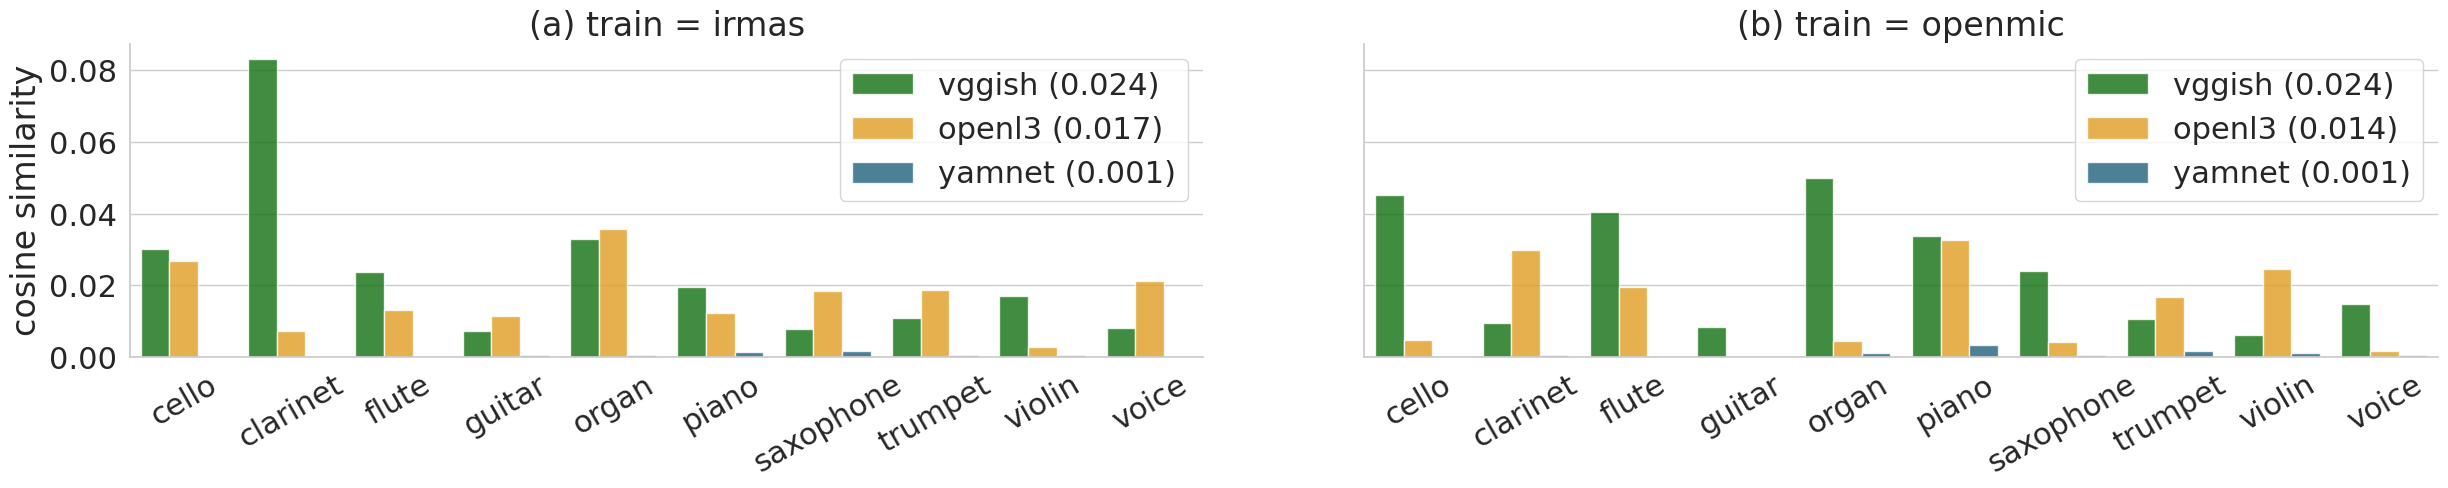

In [4]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=2)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2.5, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1, loc=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1, loc=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
plt.savefig('results/cosine_similarity.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

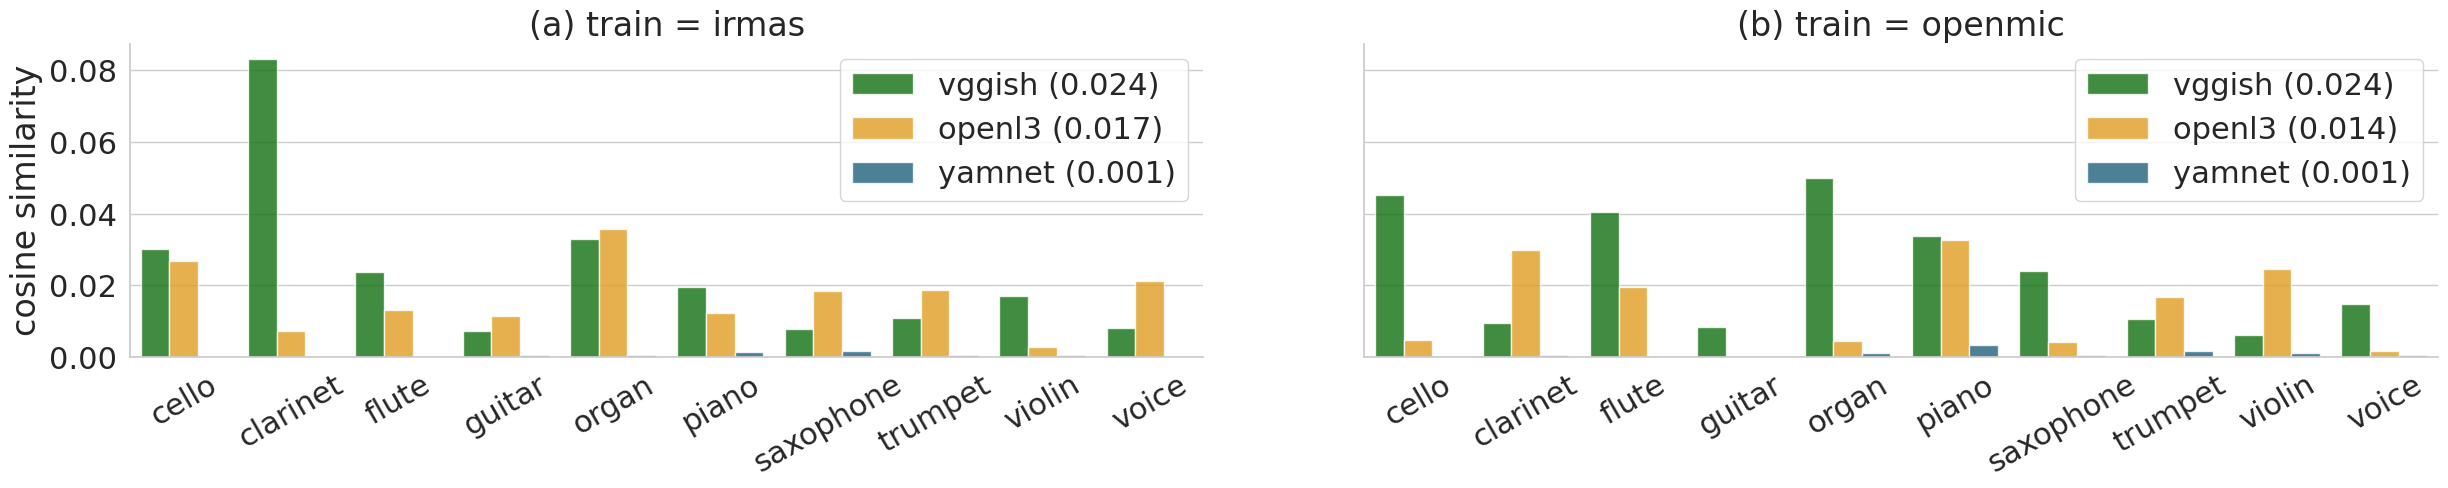

In [5]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=2)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2.5, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1, loc=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1, loc=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
plt.savefig('results/cosine_similarity.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

# cosine similarity - kernelized space

In [6]:
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })
project_method = '-klda'

for instrument in class_align:
    for embedding in ['vggish', 'openl3', 'yamnet']:
        for train_set in ['irmas', 'openmic']:

            embedding_sim = pd.DataFrame({'instrument': [],
                'embedding': [],
                'train set': [],
                'cosine similarity': [],
                })
            
            embedding_sim['instrument'] = [instrument]
            embedding_sim['embedding'] = [embedding]
            embedding_sim['train set'] = [train_set]

            file = open('models/LDAcoef_' + train_set + '_' + embedding + project_method + '.pickle', 'rb')
            dataset_sep = pickle.load(file)
            file.close()

            # load the trained instrument classification model
            file = open('models/models_' + train_set + '_' + embedding + '-k.pickle', 'rb')
            inst_sep = pickle.load(file)
            file.close()

            embedding_sim['cosine similarity'] = [cosine_similarity(inst_sep[instrument].best_estimator_.coef_, dataset_sep[instrument])[0][0]]
            
            cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv('results/cosine_similarity-k.csv', index=False)

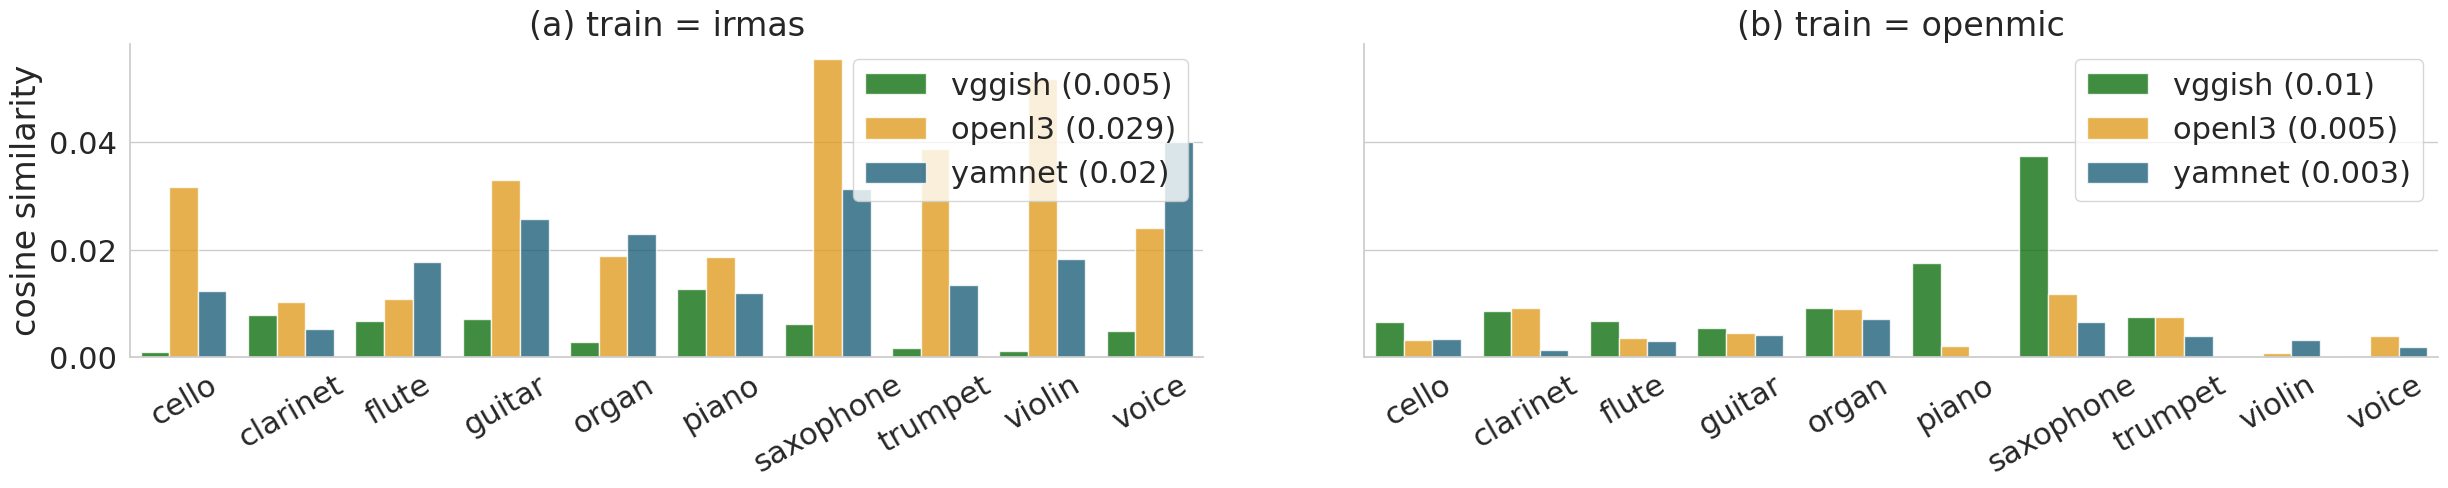

In [9]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=2)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity-k.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2.5, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1, loc=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1, loc=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
# plt.savefig('results/cosine_similarity.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

In [8]:
cosine_sim

,instrument,embedding,train set,cosine similarity
0,cello,vggish,irmas,0.000932
0,cello,vggish,openmic,-0.006408
0,cello,openl3,irmas,-0.031663
0,cello,openl3,openmic,-0.003108
0,cello,yamnet,irmas,-0.012239
0,cello,yamnet,openmic,-0.003332
0,clarinet,vggish,irmas,0.007839
0,clarinet,vggish,openmic,-0.008606
0,clarinet,openl3,irmas,-0.010134
0,clarinet,openl3,openmic,-0.009073
